In [1]:
import os
import time
import json
import joblib
import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_style("whitegrid")

In [7]:
# temp_data_1 = pd.read_excel('../data1/First_cut_ExampleData.xlsx', engine='openpyxl')
# temp_data_1.head()

,Day,Pattern,Variant,ApplicableDays,TrainType,Vervoerder,TrainCharacteristic,Trainnumber,Location,Past_Location,Activity,Ordernumber,PlannedTime,Track,BareDrivingTime,SlackPercentage,TractionType,TimetableSpeed
0,2017-09-05,A1500,280,JJJJJNN,R,NS-Reizigers,IC,1522,Dv,NaN,V,1,2017-09-05 07:18:00,1,NaN,NaN,ICM7,140
1,2017-09-05,A1500,280,JJJJJNN,R,NS-Reizigers,IC,1522,Twl,Dv,D,2,2017-09-05 07:21:00,2,227.0,NaN,ICM7,140
2,2017-09-05,A1500,280,JJJJJNN,R,NS-Reizigers,IC,1522,Apdo,Twl,D,3,2017-09-05 07:25:00,2,194.0,NaN,ICM7,140
3,2017-09-05,A1500,280,JJJJJNN,R,NS-Reizigers,IC,1522,Apda,Apdo,D,4,2017-09-05 07:26:00,DD,67.0,NaN,ICM7,140
4,2017-09-05,A1500,280,JJJJJNN,R,NS-Reizigers,IC,1522,Apd,Apda,A,5,2017-09-05 07:28:00,1,73.0,"7,0",ICM7,140


In [10]:
# temp_data_2 = pd.read_excel('../data1/Data_RAS/infra_overview.xlsx', engine='openpyxl')
# temp_data_2.head()

,FromLocation,FullNameFromLocation,ToLocation,FullNameToLocation,Hectometers,AverageAllowedSpeed,NumberOfParallelTracks,Diesel/Electric
0,Ac,Abcoude,Ashd,Amsterdam Holendrecht,23,120,4,E
1,Ac,Abcoude,Bkl,Breukelen,125,120,4,E
2,Adh,Achter de Hoven,Lw,Leeuwarden,20,100,1,D
3,Adh,Achter de Hoven,Lwc,Leeuwarden Camminghaburen,17,100,1,D
4,Ah,Arnhem,Ahp,Arnhem Velperpoort,13,100,2,E


## 距离表

In [12]:
# locations_dis = pd.read_csv('../data1/Data_RAS/LocationDistances.csv')
# locations_dis.head()

,from,to,distance
0,Ods,Dgrw,0.3
1,Dgrw,Asdma,1.9
2,Asdma,Asdm,0.9
3,Asdm,Asa,2.1
4,Asa,Dvd,2.9


In [13]:
# locations = locations_dis.groupby(by=['from'])
# len(locations)

472

## 时间表(可能用不到)

In [14]:
# time_tables = pd.read_csv('../data1/Data_RAS/TimeTable.csv')
# time_tables.head()

,Day,Trainnumber,Direction,Location,Abroad,Activity,Ordernumber,PlannedTime,TrainCharacteristic,Pattern,BareDrivingTime,TractionType,TimetableSpeed
0,4-9-2017,511,O,Zl,N,V,1.0,4-9-2017 05:44,IC,B500,NaN,ICM12,140.0
1,4-9-2017,511,O,Zlgea,N,D,2.0,4-9-2017 05:45,IC,B500,124.0,ICM12,140.0
2,4-9-2017,511,O,Hea,N,D,3.0,4-9-2017 05:47,IC,B500,123.0,ICM12,140.0
3,4-9-2017,511,O,Ddv,N,D,4.0,4-9-2017 05:52,IC,B500,287.0,ICM12,140.0
4,4-9-2017,511,O,Mp,N,K_A,5.0,4-9-2017 06:00,IC,B500,399.0,ICM12,140.0


## 1. 数据预处理

### 1.1 读取数据

`The activity of this train. Where a V stands for a departure, a D stands for a passage, and an A stands for an arrival. A K can be added in front to indicate a short stop, which is an arrival and departure planned within the same minute.`

由于数据集较大，所以先采用测试数据集进行处理，去掉了cause这一列，后续可以加上自然语言处理对原因进行分析，给级别来作为特征

In [2]:
datas = pd.read_csv('../data1/Data_RAS/RealisationData.csv')
datas = datas.drop(columns=['Cause'])

In [3]:
datas.shape

(9156970, 10)

### 1.2 取合理的延时时间范围

#### 1.2.1 查看测试集的时间范围（左侧是范围，右侧是数量）

In [116]:
print(sorted(test_datas['Delay_min'].value_counts().index.tolist()))
test_datas['Delay_min'].value_counts()

[-14, -13, -10, -9, -8, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26]


 0     6842
 1     3370
 2     1466
 3      794
 4      416
 5      301
-1      180
 6      156
 8       80
 9       68
 7       57
 15      47
 10      46
 17      42
 16      37
 11      28
 18      26
-2       26
 14      22
 20      21
 12      17
 22      17
 19      17
 13      10
-3        8
 21       6
-9        4
-6        4
-14       3
-13       3
 24       2
-5        2
-4        2
 25       1
-10       1
 26       1
-8        1
Name: Delay_min, dtype: int64

#### 1.2.2 查看训练集的时间范围

In [118]:
print(sorted(datas['Delay_min'].value_counts().index.tolist()))
datas['Delay_min'].value_counts()

[-1440, -1438, -1433, -958, -953, -952, -934, -925, -923, -920, -908, -865, -811, -808, -731, -718, -569, -554, -553, -547, -452, -442, -293, -269, -264, -263, -261, -219, -178, -170, -167, -164, -154, -153, -152, -151, -150, -127, -125, -123, -110, -109, -107, -106, -100, -95, -89, -88, -87, -84, -78, -77, -76, -75, -74, -73, -72, -71, -70, -68, -60, -59, -58, -57, -56, -55, -54, -53, -52, -51, -50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92

 0      5268376
 1      1819551
 2       716652
 3       361479
-1       222888
         ...   
 230          1
 218          1
 217          1
 206          1
 188          1
Name: Delay_min, Length: 310, dtype: int64

#### 1.2.3 取合适的范围

In [4]:
process_data = datas[(datas['Delay_min'] > -20) & (datas['Delay_min'] < 30)]
process_data

,TrafficDate,Trainseries,TrainCharacteristic,Trainnumber,Location,Activity,PlannedTime,Realisation,Delay_min,DelayJump
0,2017-09-04,500E,IC,512,Ut,V,2017-09-04 06:18:00,2017-09-04 06:18:49,0,0
1,2017-09-04,500E,IC,512,Utwa,D,2017-09-04 06:19:00,2017-09-04 06:20:48,1,1
2,2017-09-04,500E,IC,512,Utlr,D,2017-09-04 06:20:00,2017-09-04 06:22:08,2,1
3,2017-09-04,500E,IC,512,Utt,D,2017-09-04 06:21:00,2017-09-04 06:22:56,1,-1
4,2017-09-04,500E,IC,512,Vtn,D,2017-09-04 06:22:00,2017-09-04 06:23:52,1,0
...,...,...,...,...,...,...,...,...,...,...
9156965,2017-12-08,820000O,LM,828329,Bkp,D,2017-12-08 16:35:00,2017-12-08 16:35:53,0,0
9156966,2017-12-08,820000O,LM,828329,Blo,A,2017-12-08 16:36:00,2017-12-08 16:36:09,0,0
9156967,2017-12-08,820000O,LM,828329,Blo,V,2017-12-08 16:43:00,2017-12-08 16:49:58,6,6
9156968,2017-12-08,820000O,LM,828329,Blz,D,2017-12-08 16:44:00,2017-12-08 16:51:43,7,1


In [5]:
del datas

In [120]:
# activities = process_data.groupby(by=['Delay_min'])
# for group, _ in activities:
#     print(group)

### 1.3 对时间进行转换为时间戳 (分两次使用，进行结果对比)

In [80]:
def todatetime(data):
    if isinstance(data, str):
        pass
    else:
        data = str(data)
    return int(time.mktime(time.strptime(data, '%Y-%m-%d %H:%M:%S')))

In [7]:
process_data['PlannedTime'] = process_data['PlannedTime'].apply(todatetime)

In [8]:
process_data['Realisation'] = process_data['Realisation'].apply(todatetime)
process_data

,TrafficDate,Trainseries,TrainCharacteristic,Trainnumber,Location,Activity,PlannedTime,Realisation,Delay_min,DelayJump
0,2017-09-04,500E,IC,512,Ut,V,1504477080,1504477129,0,0
1,2017-09-04,500E,IC,512,Utwa,D,1504477140,1504477248,1,1
2,2017-09-04,500E,IC,512,Utlr,D,1504477200,1504477328,2,1
3,2017-09-04,500E,IC,512,Utt,D,1504477260,1504477376,1,-1
4,2017-09-04,500E,IC,512,Vtn,D,1504477320,1504477432,1,0
...,...,...,...,...,...,...,...,...,...,...
9156965,2017-12-08,820000O,LM,828329,Bkp,D,1512722100,1512722153,0,0
9156966,2017-12-08,820000O,LM,828329,Blo,A,1512722160,1512722169,0,0
9156967,2017-12-08,820000O,LM,828329,Blo,V,1512722580,1512722998,6,6
9156968,2017-12-08,820000O,LM,828329,Blz,D,1512722640,1512723103,7,1


### 1.4 加入距离参数

In [24]:
# 得到一个对应关系，方便匹配，采用哈希存储，降低时间复杂度
locations_datas = locations_dis.values.tolist()
locations_json = {}
for locations_data in locations_datas:
    if locations_data[0] not in locations_json.keys():
        locations_json[locations_data[0]] = [[locations_data[1], locations_data[2]]]
    else:
        locations_json[locations_data[0]].append([locations_data[1], locations_data[2]])
# locations_json

In [25]:
# with open('./locations.json', 'w') as f:
#     json.dump(locations_json, f)

In [9]:
def read_json(file='./locations.json'):
    with open(file, 'r') as f:
        r = json.load(f)
    return r

locations_json = read_json()

In [10]:
extract_numbers = process_data[['Trainnumber', 'Location']].values.tolist()

In [11]:
distances = []
got_number = []
departure = ''

for index, extract_number in enumerate(extract_numbers):
    if extract_number[0] not in got_number:
        got_number.append(extract_number[0])
        distance = 0
    else:
        distance = -1.
        try:
            dises = locations_json[extract_numbers[index-1][1]]
            for dis in dises:
                if dis[0] == extract_number[1]:
                    distance = dis[1]
                    break
        except:
            pass
    distances.append(distance)
process_data['distance'] = distances
process_data

,TrafficDate,Trainseries,TrainCharacteristic,Trainnumber,Location,Activity,PlannedTime,Realisation,Delay_min,DelayJump,distance
0,2017-09-04,500E,IC,512,Ut,V,1504477080,1504477129,0,0,0.0
1,2017-09-04,500E,IC,512,Utwa,D,1504477140,1504477248,1,1,1.4
2,2017-09-04,500E,IC,512,Utlr,D,1504477200,1504477328,2,1,1.9
3,2017-09-04,500E,IC,512,Utt,D,1504477260,1504477376,1,-1,1.7
4,2017-09-04,500E,IC,512,Vtn,D,1504477320,1504477432,1,0,2.1
...,...,...,...,...,...,...,...,...,...,...,...
9156965,2017-12-08,820000O,LM,828329,Bkp,D,1512722100,1512722153,0,0,0.4
9156966,2017-12-08,820000O,LM,828329,Blo,A,1512722160,1512722169,0,0,0.3
9156967,2017-12-08,820000O,LM,828329,Blo,V,1512722580,1512722998,6,6,-1.0
9156968,2017-12-08,820000O,LM,828329,Blz,D,1512722640,1512723103,7,1,0.9


In [12]:
del locations_json, extract_numbers

In [13]:
# 将没有距离的数据去掉
process_data = process_data[process_data['distance'] != -1]
process_data

,TrafficDate,Trainseries,TrainCharacteristic,Trainnumber,Location,Activity,PlannedTime,Realisation,Delay_min,DelayJump,distance
0,2017-09-04,500E,IC,512,Ut,V,1504477080,1504477129,0,0,0.0
1,2017-09-04,500E,IC,512,Utwa,D,1504477140,1504477248,1,1,1.4
2,2017-09-04,500E,IC,512,Utlr,D,1504477200,1504477328,2,1,1.9
3,2017-09-04,500E,IC,512,Utt,D,1504477260,1504477376,1,-1,1.7
4,2017-09-04,500E,IC,512,Vtn,D,1504477320,1504477432,1,0,2.1
...,...,...,...,...,...,...,...,...,...,...,...
9156964,2017-12-08,820000O,LM,828329,Blw,D,1512722100,1512722071,0,0,0.9
9156965,2017-12-08,820000O,LM,828329,Bkp,D,1512722100,1512722153,0,0,0.4
9156966,2017-12-08,820000O,LM,828329,Blo,A,1512722160,1512722169,0,0,0.3
9156968,2017-12-08,820000O,LM,828329,Blz,D,1512722640,1512723103,7,1,0.9


### 1.5 得出上一站的延迟时间

In [14]:
extract_minines = process_data[['Trainnumber', 'Delay_min']].values.tolist()

In [15]:
pre_delays = []
departure = ''

temp_number = extract_minines[0][0]
print(temp_number)
for index, extract_minine in enumerate(extract_minines):
    if temp_number != extract_minine[0]:
        # 能不用列表就少用，减少内存消耗
#         got_number.append(extract_number[0])
        temp_number = extract_minine[0]
        pre_delay = 0
    else:
        pre_delay = -1.
        try:
            pre_delay = extract_minines[index-1][1]
        except:
            pass
    pre_delays.append(pre_delay)
process_data['PreDelay_min'] = pre_delays
process_data['PreDelay_min'][0] = 0
process_data

512


,TrafficDate,Trainseries,TrainCharacteristic,Trainnumber,Location,Activity,PlannedTime,Realisation,Delay_min,DelayJump,distance,PreDelay_min
0,2017-09-04,500E,IC,512,Ut,V,1504477080,1504477129,0,0,0.0,0
1,2017-09-04,500E,IC,512,Utwa,D,1504477140,1504477248,1,1,1.4,0
2,2017-09-04,500E,IC,512,Utlr,D,1504477200,1504477328,2,1,1.9,1
3,2017-09-04,500E,IC,512,Utt,D,1504477260,1504477376,1,-1,1.7,2
4,2017-09-04,500E,IC,512,Vtn,D,1504477320,1504477432,1,0,2.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9156964,2017-12-08,820000O,LM,828329,Blw,D,1512722100,1512722071,0,0,0.9,0
9156965,2017-12-08,820000O,LM,828329,Bkp,D,1512722100,1512722153,0,0,0.4,0
9156966,2017-12-08,820000O,LM,828329,Blo,A,1512722160,1512722169,0,0,0.3,0
9156968,2017-12-08,820000O,LM,828329,Blz,D,1512722640,1512723103,7,1,0.9,0


In [16]:
del extract_minines

### 1.6 将上一站计划时间与实际到达时间赋给下一站

In [17]:
extract_times = process_data[['Trainnumber', 'PlannedTime', 'Realisation']].values.tolist()

In [18]:
pre_plantimes = []
pre_realtimes = []

departure = ''

temp_number = extract_times[0][0]
print(temp_number)
for index, extract_time in enumerate(extract_times):
    # 如果是始发站，那么时间就赋予它原来的时间
    if temp_number != extract_minine[0]:
#         got_number.append(extract_number[0])
        temp_number = extract_minine[0]
        pre_plantime = extract_time[1]
        pre_realtime = extract_time[2]
    # 非始发站，时间赋予上一站的时间
    else:
        pre_plantime = extract_times[index-1][1]
        pre_realtime = extract_times[index-1][2]
    pre_plantimes.append(pre_plantime)
    pre_realtimes.append(pre_realtime)
    
process_data['Pre_plantimes'] = pre_plantimes
process_data['Pre_realtimes'] = pre_realtimes
process_data

512


,TrafficDate,Trainseries,TrainCharacteristic,Trainnumber,Location,Activity,PlannedTime,Realisation,Delay_min,DelayJump,distance,PreDelay_min,Pre_plantimes,Pre_realtimes
0,2017-09-04,500E,IC,512,Ut,V,1504477080,1504477129,0,0,0.0,0,1504477080,1504477129
1,2017-09-04,500E,IC,512,Utwa,D,1504477140,1504477248,1,1,1.4,0,1504477080,1504477129
2,2017-09-04,500E,IC,512,Utlr,D,1504477200,1504477328,2,1,1.9,1,1504477140,1504477248
3,2017-09-04,500E,IC,512,Utt,D,1504477260,1504477376,1,-1,1.7,2,1504477200,1504477328
4,2017-09-04,500E,IC,512,Vtn,D,1504477320,1504477432,1,0,2.1,1,1504477260,1504477376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9156964,2017-12-08,820000O,LM,828329,Blw,D,1512722100,1512722071,0,0,0.9,0,1512721860,1512721819
9156965,2017-12-08,820000O,LM,828329,Bkp,D,1512722100,1512722153,0,0,0.4,0,1512722100,1512722071
9156966,2017-12-08,820000O,LM,828329,Blo,A,1512722160,1512722169,0,0,0.3,0,1512722100,1512722153
9156968,2017-12-08,820000O,LM,828329,Blz,D,1512722640,1512723103,7,1,0.9,0,1512722160,1512722169


In [19]:
del pre_plantimes, pre_realtimes

### 1.7 时间求差

In [20]:
process_data['residual'] = process_data['PlannedTime'] - process_data['Pre_realtimes']
process_data

,TrafficDate,Trainseries,TrainCharacteristic,Trainnumber,Location,Activity,PlannedTime,Realisation,Delay_min,DelayJump,distance,PreDelay_min,Pre_plantimes,Pre_realtimes,residual
0,2017-09-04,500E,IC,512,Ut,V,1504477080,1504477129,0,0,0.0,0,1504477080,1504477129,-49
1,2017-09-04,500E,IC,512,Utwa,D,1504477140,1504477248,1,1,1.4,0,1504477080,1504477129,11
2,2017-09-04,500E,IC,512,Utlr,D,1504477200,1504477328,2,1,1.9,1,1504477140,1504477248,-48
3,2017-09-04,500E,IC,512,Utt,D,1504477260,1504477376,1,-1,1.7,2,1504477200,1504477328,-68
4,2017-09-04,500E,IC,512,Vtn,D,1504477320,1504477432,1,0,2.1,1,1504477260,1504477376,-56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9156964,2017-12-08,820000O,LM,828329,Blw,D,1512722100,1512722071,0,0,0.9,0,1512721860,1512721819,281
9156965,2017-12-08,820000O,LM,828329,Bkp,D,1512722100,1512722153,0,0,0.4,0,1512722100,1512722071,29
9156966,2017-12-08,820000O,LM,828329,Blo,A,1512722160,1512722169,0,0,0.3,0,1512722100,1512722153,7
9156968,2017-12-08,820000O,LM,828329,Blz,D,1512722640,1512723103,7,1,0.9,0,1512722160,1512722169,471


## 2. 制作标签建立训练集和测试集

- [pass!] 将延时时间小于等于0的置为1，其余置为0，归为二分类问题
- 做回归预测

In [131]:
# def get_label(data):
#     if data <= 0:
#         return 1
#     else:
#         return 0
    
# process_data['labels'] = process_data['Delay_min'].apply(get_label)
# process_data

### 2.1 对 `Activity` 这一列进行 `one-hot` 化

In [21]:
# 需要将状态转换成int型，因此对其one-hot化
df_activity = pd.get_dummies(process_data['Activity'], prefix='Activity')
process_data_final = pd.concat([process_data, df_activity], axis=1)
process_data_final

,TrafficDate,Trainseries,TrainCharacteristic,Trainnumber,Location,Activity,PlannedTime,Realisation,Delay_min,DelayJump,distance,PreDelay_min,Pre_plantimes,Pre_realtimes,residual,Activity_A,Activity_D,Activity_K_A,Activity_K_V,Activity_V
0,2017-09-04,500E,IC,512,Ut,V,1504477080,1504477129,0,0,0.0,0,1504477080,1504477129,-49,0,0,0,0,1
1,2017-09-04,500E,IC,512,Utwa,D,1504477140,1504477248,1,1,1.4,0,1504477080,1504477129,11,0,1,0,0,0
2,2017-09-04,500E,IC,512,Utlr,D,1504477200,1504477328,2,1,1.9,1,1504477140,1504477248,-48,0,1,0,0,0
3,2017-09-04,500E,IC,512,Utt,D,1504477260,1504477376,1,-1,1.7,2,1504477200,1504477328,-68,0,1,0,0,0
4,2017-09-04,500E,IC,512,Vtn,D,1504477320,1504477432,1,0,2.1,1,1504477260,1504477376,-56,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9156964,2017-12-08,820000O,LM,828329,Blw,D,1512722100,1512722071,0,0,0.9,0,1512721860,1512721819,281,0,1,0,0,0
9156965,2017-12-08,820000O,LM,828329,Bkp,D,1512722100,1512722153,0,0,0.4,0,1512722100,1512722071,29,0,1,0,0,0
9156966,2017-12-08,820000O,LM,828329,Blo,A,1512722160,1512722169,0,0,0.3,0,1512722100,1512722153,7,1,0,0,0,0
9156968,2017-12-08,820000O,LM,828329,Blz,D,1512722640,1512723103,7,1,0.9,0,1512722160,1512722169,471,0,1,0,0,0


In [22]:
df_activity.columns

Index(['Activity_A', 'Activity_D', 'Activity_K_A', 'Activity_K_V',
       'Activity_V'],
      dtype='object')

In [23]:
del df_activity

### 保存下处理后的数据，方便下次打开再次使用

In [26]:
# process_data_final.to_csv('./train_test_split_data.csv', index=False)

In [2]:
process_data_final = pd.read_csv('./train_test_split_data.csv')
process_data_final.head()

,TrafficDate,Trainseries,TrainCharacteristic,Trainnumber,Location,Activity,PlannedTime,Realisation,Delay_min,DelayJump,distance,PreDelay_min,Pre_plantimes,Pre_realtimes,residual,Activity_A,Activity_D,Activity_K_A,Activity_K_V,Activity_V
0,2017-09-04,500E,IC,512,Ut,V,1504477080,1504477129,0,0,0.0,0,1504477080,1504477129,-49,0,0,0,0,1
1,2017-09-04,500E,IC,512,Utwa,D,1504477140,1504477248,1,1,1.4,0,1504477080,1504477129,11,0,1,0,0,0
2,2017-09-04,500E,IC,512,Utlr,D,1504477200,1504477328,2,1,1.9,1,1504477140,1504477248,-48,0,1,0,0,0
3,2017-09-04,500E,IC,512,Utt,D,1504477260,1504477376,1,-1,1.7,2,1504477200,1504477328,-68,0,1,0,0,0
4,2017-09-04,500E,IC,512,Vtn,D,1504477320,1504477432,1,0,2.1,1,1504477260,1504477376,-56,0,1,0,0,0


In [3]:
features = process_data_final[['Activity_A', 'Activity_D', 'Activity_K_A', 'Activity_K_V', 'Activity_V', 'distance', 'PreDelay_min']]
features.shape

(7939451, 7)

In [4]:
labels = process_data_final[['Delay_min']]

In [5]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7939451 entries, 0 to 7939450
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Activity_A    int64  
 1   Activity_D    int64  
 2   Activity_K_A  int64  
 3   Activity_K_V  int64  
 4   Activity_V    int64  
 5   distance      float64
 6   PreDelay_min  int64  
dtypes: float64(1), int64(6)
memory usage: 424.0 MB


In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7939451 entries, 0 to 7939450
Data columns (total 1 columns):
 #   Column     Dtype
---  ------     -----
 0   Delay_min  int64
dtypes: int64(1)
memory usage: 60.6 MB


### 2.2 分训练集和验证集



In [7]:
pca = PCA(n_components=0.95)
features = pca.fit_transform(features)
features.shape

(7939451, 2)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=20)

### 2.3 标准化特征

对数据集进行标准化，不然MSE较大（在未标准化数据之前得到的MSE过百）

In [9]:
ss_X = StandardScaler()
ss_y = StandardScaler()

X_train = ss_X.fit_transform(X_train)
X_test = ss_X.transform(X_test)

y_train = ss_y.fit_transform(y_train)
y_test = ss_y.transform(y_test)

## 3. 预测

In [10]:
def mse(x, y):
    return np.linalg.norm(x - y)

### 3.1 线性回归做Baseline

In [11]:
clf_linear = LinearRegression()
clf_linear.fit(X_train, y_train)
y_predict_linear = clf_linear.predict(X_test)

y_predict_linear = y_predict_linear.reshape(-1, 1)

In [12]:
mse_error_linear = mse(y_predict_linear, y_test)
print(f'The MSE Error is :{mse_error_linear:.4f}')

The MSE Error is :466.7321


In [13]:
print(f'R-squared value of linear regression is {clf_linear.score(X_test, y_test):.4f}')
print(f'The mean squared error of linear regression is {mean_squared_error(ss_y.inverse_transform(y_test), ss_y.inverse_transform(y_predict_linear)):.4f}')
print(f'The mean absoluate error of linear regression is {mean_absolute_error(ss_y.inverse_transform(y_test), ss_y.inverse_transform(y_predict_linear)):.4f}')

# print(f'The mean squared error of linear regression is {mean_squared_error(y_test, y_predict_linear):.4f}')
# print(f'The mean absoluate error of linear regression is {mean_absolute_error(y_test, y_predict_linear):.4f}')

R-squared value of linear regression is 0.8627
The mean squared error of linear regression is 0.7819
The mean absoluate error of linear regression is 0.4182


---

## 4. 加入时间变量做预测

### 4.1 分离特征和标签，特征中加入时间变量

由于当前时间变量是未知的，所以只能取上一车次的时间变量，类似于距离，同样增加新的两列参数，求得这一列车与上一列到达时间的残差，并将计划时间与残差均放入特征中

In [34]:
features = process_data_final[['Activity_A', 'Activity_D', 'Activity_K_A', 'Activity_K_V', 'Activity_V', 'distance', 'PreDelay_min', 'residual']]
labels = process_data_final[['Delay_min']]
features.shape

(7939451, 8)

In [35]:
# pca = PCA(n_components=0.95)
# features = pca.fit_transform(features)
# features.shape

### 4.2 分数据集

In [36]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=10)
residual_test = X_test[['residual']]
distance_test = X_test[['distance']]

### 4.3 标准化

In [37]:
# ss_X = StandardScaler()
# ss_y = StandardScaler()

# X_train = ss_X.fit_transform(X_train)
# X_test = ss_X.transform(X_test)

# y_train = ss_y.fit_transform(y_train)
# y_test = ss_y.transform(y_test)

### 4.4 预测

In [38]:
clf_linear = LinearRegression()
clf_linear.fit(X_train, y_train)
y_predict_linear = clf_linear.predict(X_test)

y_predict_linear = y_predict_linear.reshape(-1, 1)

In [40]:
mse_error_linear = mse(y_predict_linear, y_test)
print(f'The MSE Error is :{mse_error_linear:.4f}')

print(f'R-squared value of linear regression is {clf_linear.score(X_test, y_test):.4f}')
# print(f'The mean squared error of linear regression is {mean_squared_error(ss_y.inverse_transform(y_test), ss_y.inverse_transform(y_predict_linear)):.4f}')
# print(f'The mean absoluate error of linear regression is {mean_absolute_error(ss_y.inverse_transform(y_test), ss_y.inverse_transform(y_predict_linear)):.4f}')

print(f'The mean squared error of linear regression is {mean_squared_error(y_test, y_predict_linear):.4f}')
print(f'The mean absoluate error of linear regression is {mean_absolute_error(y_test, y_predict_linear):.4f}')

The MSE Error is :1099.2847
R-squared value of linear regression is 0.8657
The mean squared error of linear regression is 0.7610
The mean absoluate error of linear regression is 0.4360


In [41]:
ss_y.inverse_transform(y_predict_linear)

array([[0.56538533],
       [3.58544972],
       [1.22368172],
       ...,
       [1.23851601],
       [1.23917439],
       [8.07247786]])

### 4.5 保存模型

In [42]:
model_path = './models/'
joblib.dump(clf_linear, model_path + 'exp1_model.pkl')

['./models/exp1_model.pkl']

## 5. 可视化结果

### 5.1 将残差作为横坐标，预测结果和真实结果分为不同颜色显示

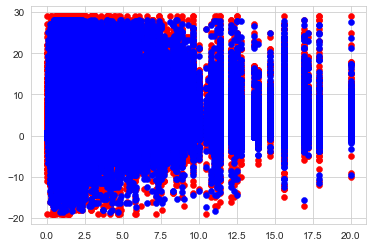

In [43]:
plt.scatter(distance_test, y_test,color='red', linewidth=0.5)
plt.scatter(distance_test, y_predict_linear,color='blue', linewidth=0.5, ls='-')

## 6. 测试集测试

In [24]:
test_datas = pd.read_csv('../data1/Data_RAS/ExampleTestSet_0800.csv')
test_datas.head()

,TrafficDate,Trainseries,TrainCharacteristic,Trainnumber,Location,Activity,PlannedTime,Realisation,Delay_min,DelayJump
0,2017-11-07,500E,IC,512,Ut,V,2017-11-07 06:18:00,2017-11-07 06:18:16,0,0
1,2017-11-07,500E,IC,512,Utwa,D,2017-11-07 06:19:00,2017-11-07 06:20:26,1,1
2,2017-11-07,500E,IC,512,Utlr,D,2017-11-07 06:20:00,2017-11-07 06:21:55,1,0
3,2017-11-07,500E,IC,512,Utt,D,2017-11-07 06:21:00,2017-11-07 06:22:54,1,0
4,2017-11-07,500E,IC,512,Vtn,D,2017-11-07 06:22:00,2017-11-07 06:23:53,1,0


In [25]:
def read_json(file):
    with open(file, 'r') as f:
        r = json.load(f)
    return r

def todatetime(data):
    if isinstance(data, str):
        pass
    else:
        data = str(data)
    return int(time.mktime(time.strptime(data, '%Y-%m-%d %H:%M:%S')))

In [26]:
test_datas['PlannedTime'] = test_datas['PlannedTime'].apply(todatetime)
test_datas['Realisation'] = test_datas['Realisation'].apply(todatetime)

In [27]:
pre_delays = []
departure = ''

# 1. 处理延时时间
extract_minines = test_datas[['Trainnumber', 'Delay_min']].values.tolist()
temp_number = extract_minines[0][0]
for index, extract_minine in enumerate(extract_minines):
    if temp_number != extract_minine[0]:
        # 能不用列表就少用，减少内存消耗
        #         got_number.append(extract_number[0])
        temp_number = extract_minine[0]
        pre_delay = 0
    else:
        pre_delay = -1.
        try:
            pre_delay = extract_minines[index - 1][1]
        except:
            pass
    pre_delays.append(pre_delay)
test_datas['PreDelay_min'] = pre_delays
test_datas['PreDelay_min'][0] = 0

In [28]:
# 2. 处理计划时间得到时间差
extract_times = test_datas[['Trainnumber', 'PlannedTime',
                            'Realisation']].values.tolist()
pre_plantimes = []
pre_realtimes = []

temp_number = extract_times[0][0]
for index, extract_time in enumerate(extract_times):
    # 如果是始发站，那么时间就赋予它原来的时间
    if temp_number != extract_minine[0]:
        #         got_number.append(extract_number[0])
        temp_number = extract_minine[0]
        pre_plantime = extract_time[1]
        pre_realtime = extract_time[2]
    # 非始发站，时间赋予上一站的时间
    else:
        pre_plantime = extract_times[index - 1][1]
        pre_realtime = extract_times[index - 1][2]
    pre_plantimes.append(pre_plantime)
    pre_realtimes.append(pre_realtime)

test_datas['Pre_plantimes'] = pre_plantimes
test_datas['Pre_realtimes'] = pre_realtimes

test_datas['residual'] = test_datas['PlannedTime'] - test_datas['Pre_realtimes']

In [29]:
# 3. 得到距离参数
locations_json = read_json('./locations.json')
distances = []
got_number = []
departure = ''

extract_numbers = test_datas[['Trainnumber', 'Location']].values.tolist()

for index, extract_number in enumerate(extract_numbers):
    if extract_number[0] not in got_number:
        got_number.append(extract_number[0])
        distance = 0
    else:
        distance = -1.
        try:
            dises = locations_json[extract_numbers[index - 1][1]]
            for dis in dises:
                if dis[0] == extract_number[1]:
                    distance = dis[1]
                    break
        except:
            pass
    distances.append(distance)
test_datas['distance'] = distances

In [30]:
# 4. 对 Activity 这一列进行 one-hot 化
df_activity = pd.get_dummies(test_datas['Activity'], prefix='Activity')
test_datas_final = pd.concat([test_datas, df_activity], axis=1)

In [31]:
test_datas_final

,TrafficDate,Trainseries,TrainCharacteristic,Trainnumber,Location,Activity,PlannedTime,Realisation,Delay_min,DelayJump,PreDelay_min,Pre_plantimes,Pre_realtimes,residual,distance,Activity_A,Activity_D,Activity_K_A,Activity_K_V,Activity_V
0,2017-11-07,500E,IC,512,Ut,V,1510006680,1510006696,0,0,0,1510006680,1510006696,-16,0.0,0,0,0,0,1
1,2017-11-07,500E,IC,512,Utwa,D,1510006740,1510006826,1,1,0,1510006680,1510006696,44,1.4,0,1,0,0,0
2,2017-11-07,500E,IC,512,Utlr,D,1510006800,1510006915,1,0,1,1510006740,1510006826,-26,1.9,0,1,0,0,0
3,2017-11-07,500E,IC,512,Utt,D,1510006860,1510006974,1,0,1,1510006800,1510006915,-55,1.7,0,1,0,0,0
4,2017-11-07,500E,IC,512,Vtn,D,1510006920,1510007033,1,0,1,1510006860,1510006974,-54,2.1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14119,2017-11-07,810000O,LM,810515,Ns,D,1510007040,1510007022,0,0,0,1510006740,1510006685,355,12.1,0,1,0,0,0
14120,2017-11-07,810000O,LM,810515,Hde,D,1510007340,1510007274,-1,-1,0,1510007040,1510007022,318,8.6,0,1,0,0,0
14121,2017-11-07,810000O,LM,810515,Htba,D,1510007700,1510007651,0,1,-1,1510007340,1510007274,426,-1.0,0,1,0,0,0
14122,2017-11-07,810000O,LM,810515,Zlra,D,1510007760,1510007716,0,0,0,1510007700,1510007651,109,1.7,0,1,0,0,0


In [44]:
features = test_datas_final[[
        'Activity_A', 'Activity_D', 'Activity_K_A', 'Activity_K_V', 'Activity_V', 'distance', 'PreDelay_min', 'residual'
    ]]

# 6. 加载模型
clf = joblib.load('./models/exp1_model.pkl')

In [46]:
# 7. 预测结果
# features = ss_X.fit_transform(features)
predict = clf.predict(features)
print(predict)

[[ 0.08630824]
 [ 0.10679248]
 [ 1.06606885]
 ...
 [-0.84947841]
 [ 0.10515155]
 [-0.17276588]]


In [76]:
print(f'The mean squared error of linear regression is {mean_squared_error(test_datas_final[["Delay_min"]], predict):.4f}')

The mean squared error of linear regression is 0.9023


### 5.3 画出回归图，简单理解就是不同颜色为不同的类

In [49]:
residual_test = features[['residual']]
distance_test = features[['distance']]

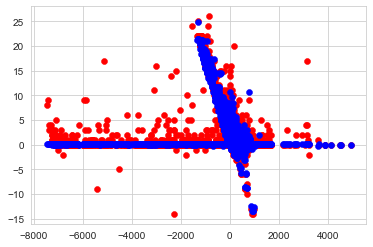

In [50]:
plt.scatter(residual_test, test_datas_final[['Delay_min']],color='red', linewidth=0.5)
plt.scatter(residual_test, predict,color='blue', linewidth=0.5, ls='-')

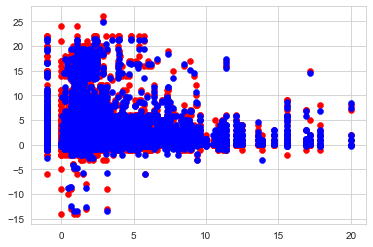

In [48]:
plt.scatter(distance_test, test_datas_final[['Delay_min']],color='red', linewidth=0.5)
plt.scatter(distance_test, predict,color='blue', linewidth=0.5, ls='-')

In [91]:
residual_sta = test_datas_final[['residual']].values.reshape(len(test_datas_final[['residual']]))
distance_sta = test_datas_final[['distance']].values.reshape(len(test_datas_final[['distance']]))
plantime_sta = test_datas_final[['PlannedTime']].values.reshape(len(test_datas_final[['PlannedTime']]))

In [99]:
sta_df = pd.DataFrame([residual_sta, distance_sta, plantime_sta]).T
sta_df.columns = ['residual', 'distance', 'PlannedTime']
sta_df['Delay_min'] = test_datas_final[['Delay_min']]
sta_df['index'] = np.arange(len(distance_sta))
sta_df

,residual,distance,PlannedTime,Delay_min,index
0,-16.0,0.0,1.510007e+09,0,0
1,44.0,1.4,1.510007e+09,1,1
2,-26.0,1.9,1.510007e+09,1,2
3,-55.0,1.7,1.510007e+09,1,3
4,-54.0,2.1,1.510007e+09,1,4
...,...,...,...,...,...
14119,355.0,12.1,1.510007e+09,0,14119
14120,318.0,8.6,1.510007e+09,-1,14120
14121,426.0,-1.0,1.510008e+09,0,14121
14122,109.0,1.7,1.510008e+09,0,14122


- 图不太合适

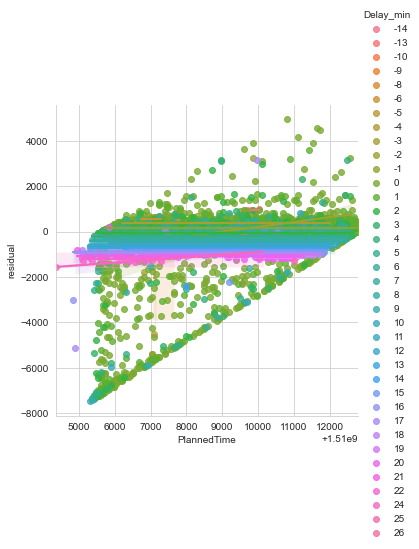

In [101]:
# np.arange(len(distance_sta))
sns.lmplot(x="PlannedTime", y="residual", data=sta_df, hue='Delay_min', size=5,order=1)

In [142]:
def check_global_variable() -> dict:
    #global_variable是一个字典，存储了当前程序所有全局变量
    global_variable = globals()
    return {
                key:value for key,value in global_variable.items()\
                #一般不希望查看所有全局变量，因此过滤掉用户自定义以外的部分
                if not (
                        key.startswith('_') \
                        or key in ('In','Out','get_ipython','exit','quit','check_global_variable') \
                        or type(value).__name__ in ('module','function')
                        )
            }